# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import itertools
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf

plt.style.use('fivethirtyeight')


## Load data

In [2]:
data_path = "../Datasets/Forecasting_data.csv"
data = pd.read_csv(data_path)
data.head()
data.drop(columns=["Unnamed: 0"],inplace=True)
data["Time"] = pd.to_datetime(data["Time"])

## Helpers

In [3]:
def create_time_series(data,col,time_col):
    series = data[[col]]
    series.set_index(data[time_col],inplace = True)
    series = series.resample(rule="D").sum()
    return series


def plot_single_series(time_series):
    fig,ax = plt.subplots(1,1,figsize = (12,8))
    time_series.plot(linestyle='-', linewidth=0.8,ax=ax)
    
    plt.title("{} Plot".format(time_series.columns[0]))
    plt.xlabel("Time")
    plt.ylabel(time_series.columns[0])
    plt.show()
    
    
def seasonal_plot(time_series, season="W"):

    if season not in ["W", "M"]:
        raise ValueError
    else:
        if season == "W":
            win_size = 7
            win_map = lambda x: x.weekday()
            title = "Weakly"

        elif season == "M":
            win_size = 30
            win_map = lambda x: x.day
            title = "Monthly"

        fig = plt.figure(figsize=(12, 8))
        by_day = time_series.resample(rule="D", how="sum")

        for i in range(by_day.shape[0] // win_size + 1):
            window_values = by_day.values[i * win_size:(i + 1) * win_size]
            days = by_day.index[i * win_size:(i + 1) * win_size].map(win_map)
            if window_values.ndim == 2:
                window_values = window_values[:, 0]
            values_dict = dict(zip(window_values, days))
            values_dict = {k: v for k, v in sorted(values_dict.items(), key=lambda item: item[1])}
            days, values = list(values_dict.values()), list(values_dict.keys())
            plt.plot(days, values, marker='.', linestyle='-', linewidth=0.95)
        plt.title("{} plot".format(title))
        plt.show()
        
        
def plot_seasonal_decomposition(data, decomposition_model="additive",freq=30):
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8

    decomposition = sm.tsa.seasonal_decompose(data, model=decomposition_model,freq=freq)
    fig = decomposition.plot()
    plt.show()
    return decomposition


def train_test_split(time_series, test_size=0.3):


    ind = int(len(time_series) * test_size)
    y_train = time_series[:-ind]
    y_test = time_series[-ind:]
    return y_train,y_test


    

## Visualize Dish1 time series

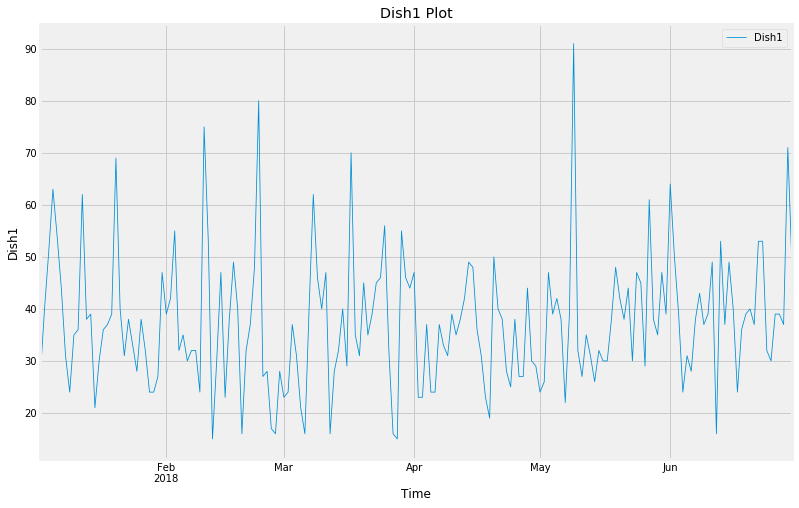

/home/garik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


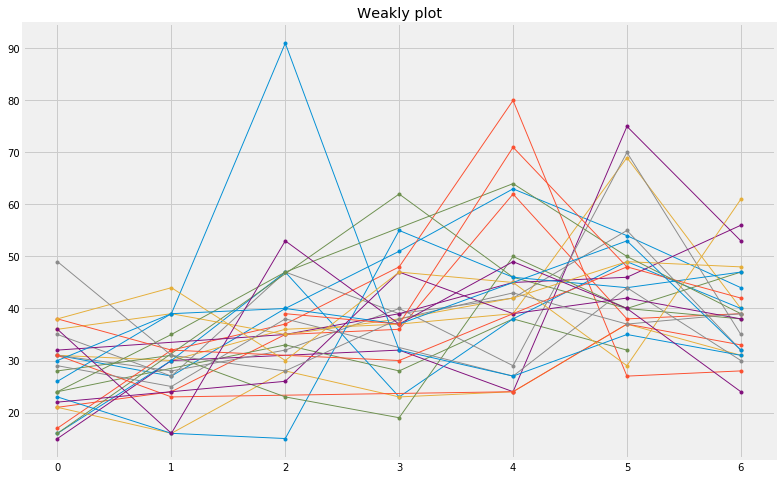

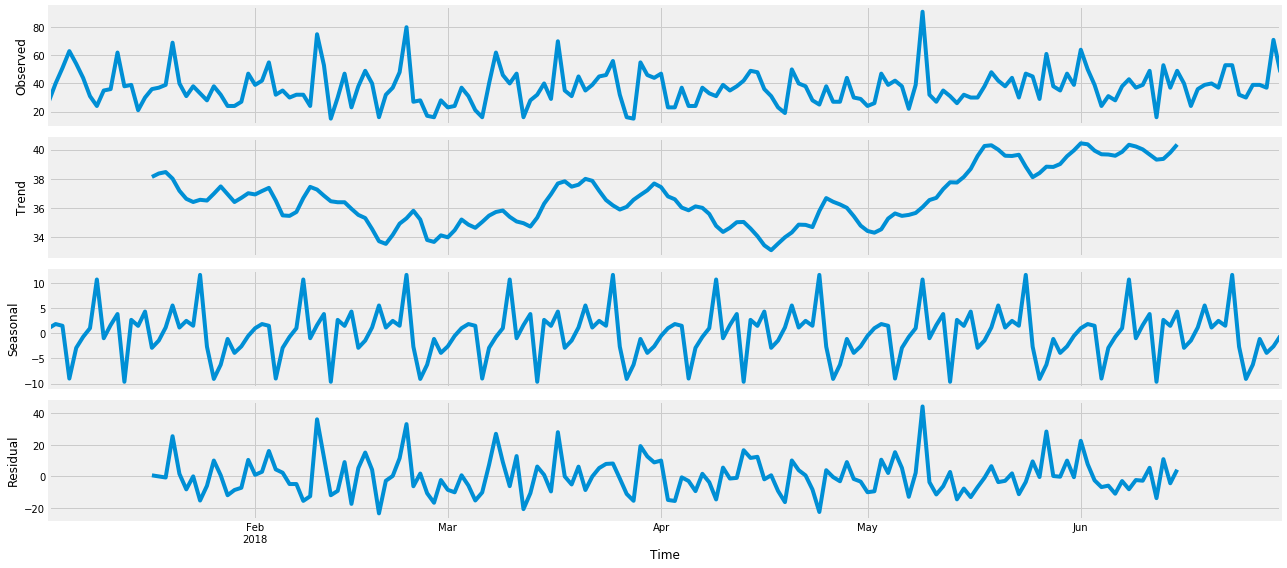

In [4]:
col1 = "Dish1"
time_col = "Time"
dish1 = create_time_series(data,col1,time_col)
plot_single_series(dish1)
seasonal_plot(dish1)
plot_seasonal_decomposition(dish1);

### Dish1 lag plots

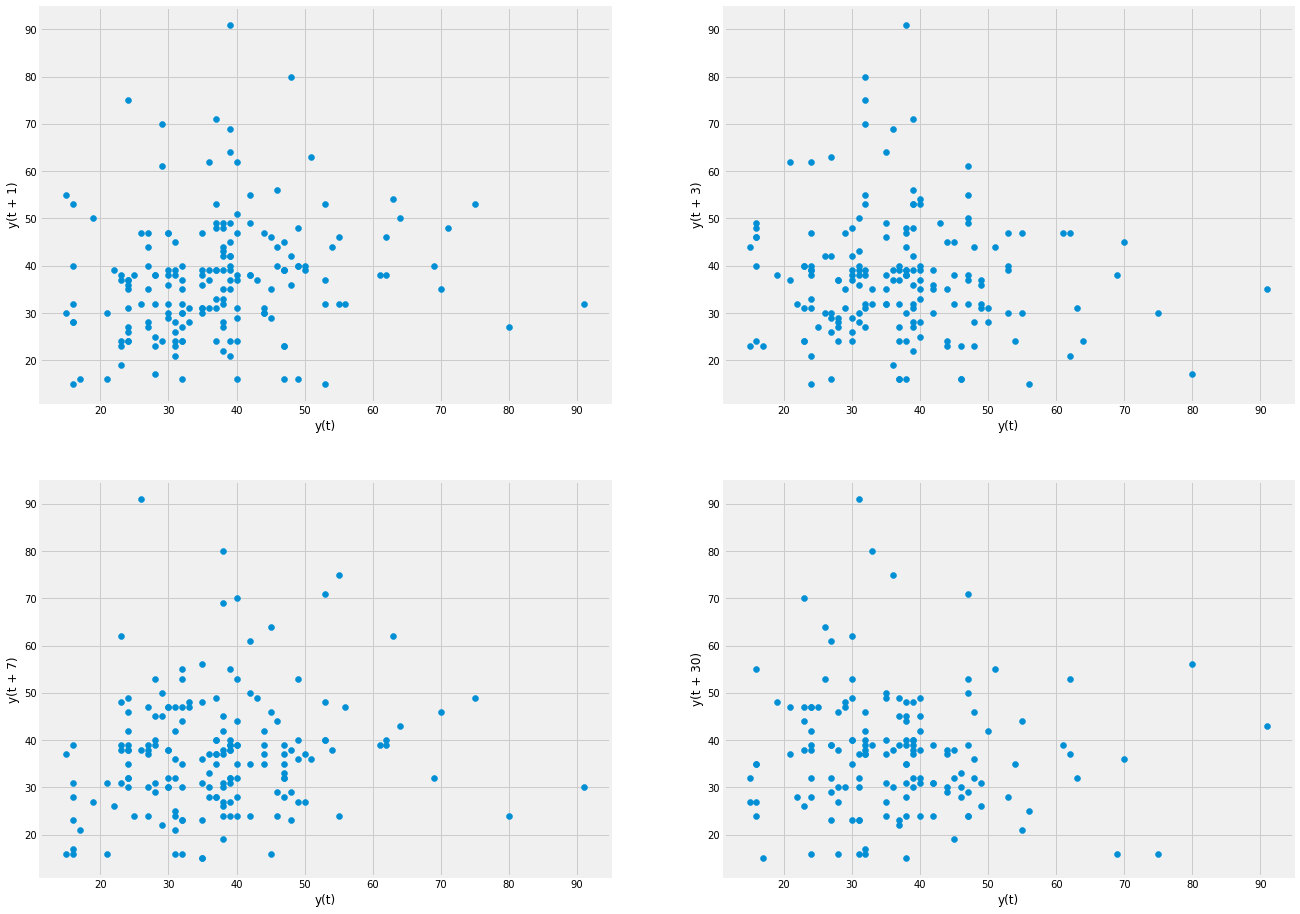

In [5]:
from pandas.plotting import lag_plot

lags = [1,3,7,30]

n_rows,n_cols = 2, len(lags)//2
fig,ax = plt.subplots(n_rows,n_cols,figsize=(20,16))

i = 0
for row in ax:
    for col in row:         
        lag_plot(dish1,lag=lags[i],ax=col)
        i+=1
plt.show()
    
    

### Dish1 autocorrelation

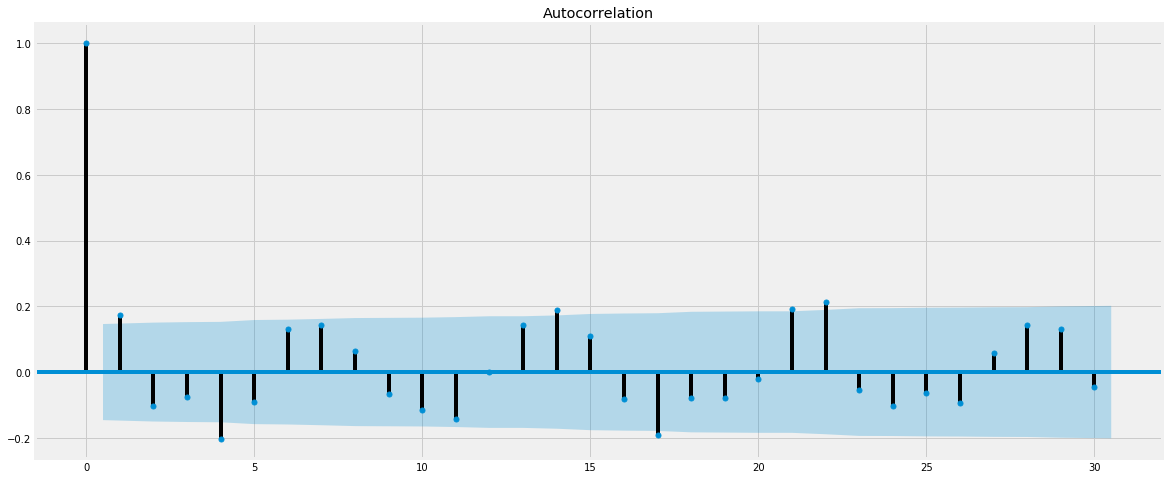

In [6]:
plot_acf(dish1,lags=30)
plt.show()

## Train Forecasting models

### Train test split

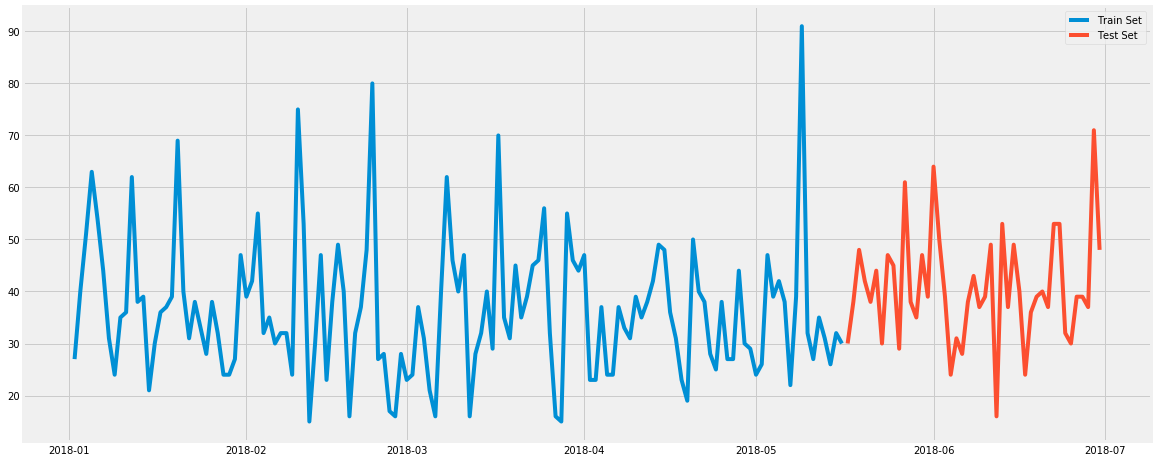

In [7]:
y_train,y_test = train_test_split(dish1,test_size=0.25)
plt.plot(y_train,label="Train Set")
plt.plot(y_test,label="Test Set")
plt.legend();

In [8]:
y_train_diff, y_test_diff = train_test_split(dish1.diff().dropna(),test_size=0.25)

### ES models

In [9]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

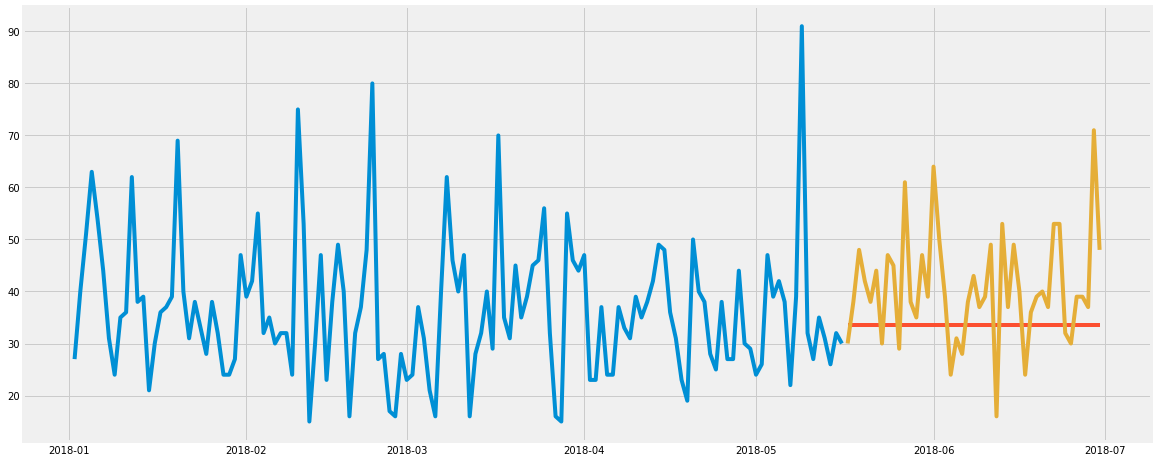

In [10]:
ses_fit_1 = SimpleExpSmoothing(y_train).fit(smoothing_level=0.2,optimized=False)
ses_1_pred = ses_fit_1.forecast(len(y_test))
plt.plot(y_train)
plt.plot(ses_1_pred)
plt.plot(y_test);

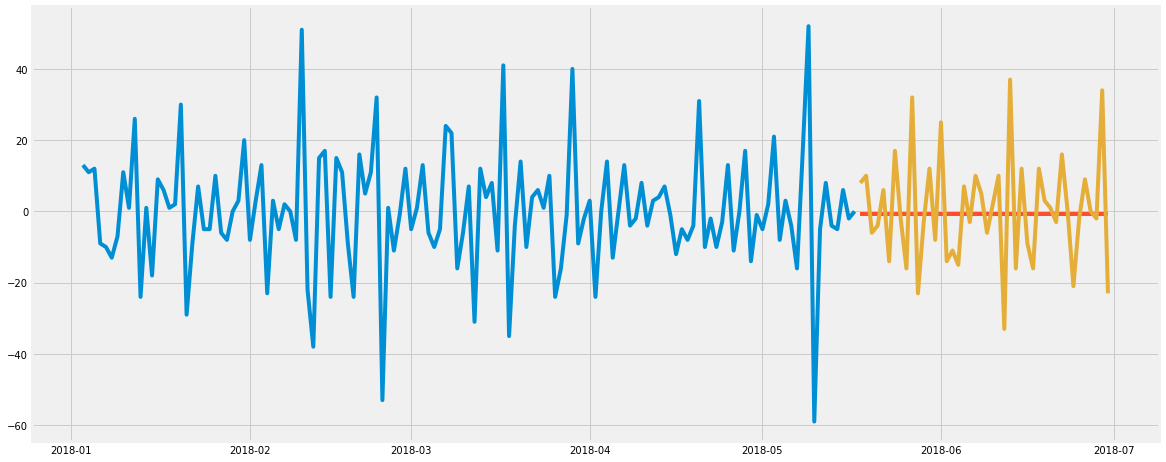

In [11]:
ses_fit_1 = SimpleExpSmoothing(y_train_diff).fit(smoothing_level=0.2,optimized=False)
ses_1_pred = ses_fit_1.forecast(len(y_test_diff))
plt.plot(y_train_diff)
plt.plot(ses_1_pred)
plt.plot(y_test_diff);

#### Search alpha for SES model

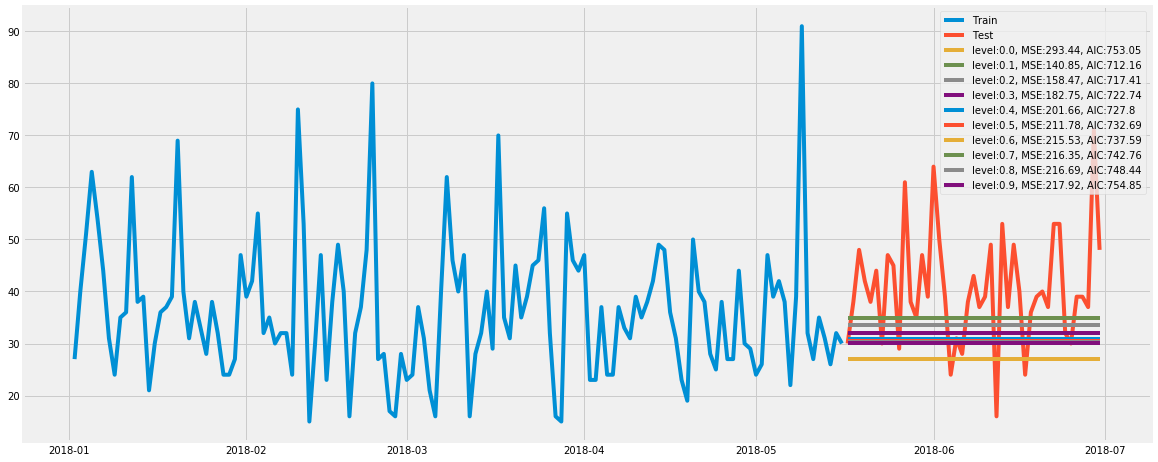

In [12]:
plt.plot(y_train,label="Train")
plt.plot(y_test,label="Test")
for level in np.arange(0,1,0.1):
    ses_fit_1 = SimpleExpSmoothing(y_train).fit(smoothing_level=level,optimized=False)
    ses_1_pred = ses_fit_1.forecast(len(y_test))
    mse = mean_squared_error(y_test, ses_1_pred)
    plt.plot(ses_1_pred,label="level:{}, MSE:{}, AIC:{}".format(np.round(level,2),
                                                               np.round(mse,2),
                                                               np.round(ses_fit_1.aic,2)));
    
plt.legend();

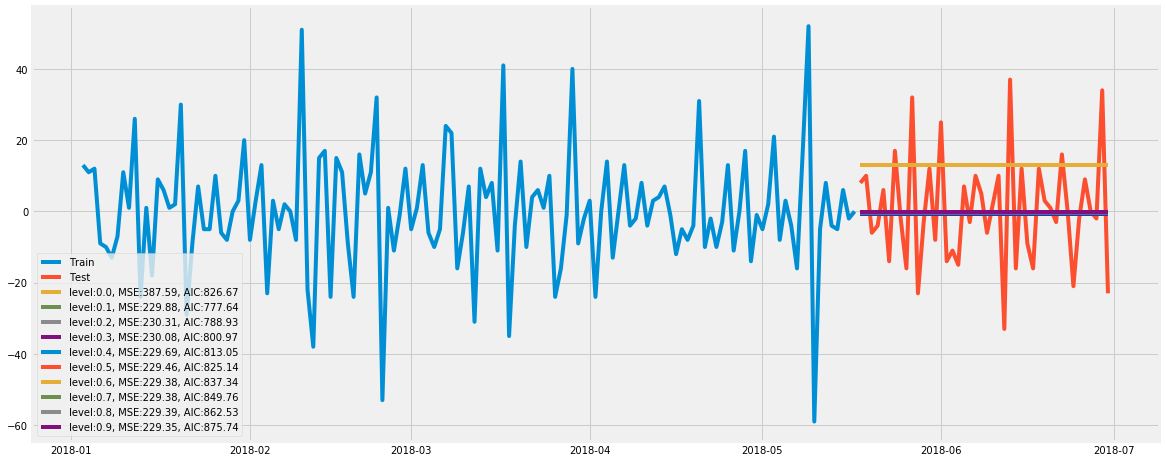

In [13]:
plt.plot(y_train_diff,label="Train")
plt.plot(y_test_diff,label="Test")
for level in np.arange(0,1,0.1):
    ses_fit_1 = SimpleExpSmoothing(y_train_diff).fit(smoothing_level=level,optimized=False)
    ses_1_pred = ses_fit_1.forecast(len(y_test_diff))
    mse = mean_squared_error(y_test_diff, ses_1_pred)
    plt.plot(ses_1_pred,label="level:{}, MSE:{}, AIC:{}".format(np.round(level,2),
                                                               np.round(mse,2),
                                                               np.round(ses_fit_1.aic,2)));
    
plt.legend();

### Grid search for Hoalt ES 

In [14]:
def model_hyparam_search(model,y_train,y_test,params_range_dict):


    params_range = list(params_range_dict.values())
    params = list(itertools.product(*params_range))

    aic, test_mse = [], []
    for param in params:
        fitted = model.fit(*param,optimized=False)
        y_pred = fitted.forecast(len(y_test))
        test_mse.append(mean_squared_error(y_pred,y_test))
        aic.append(fitted.aic)

    return test_mse,aic,params





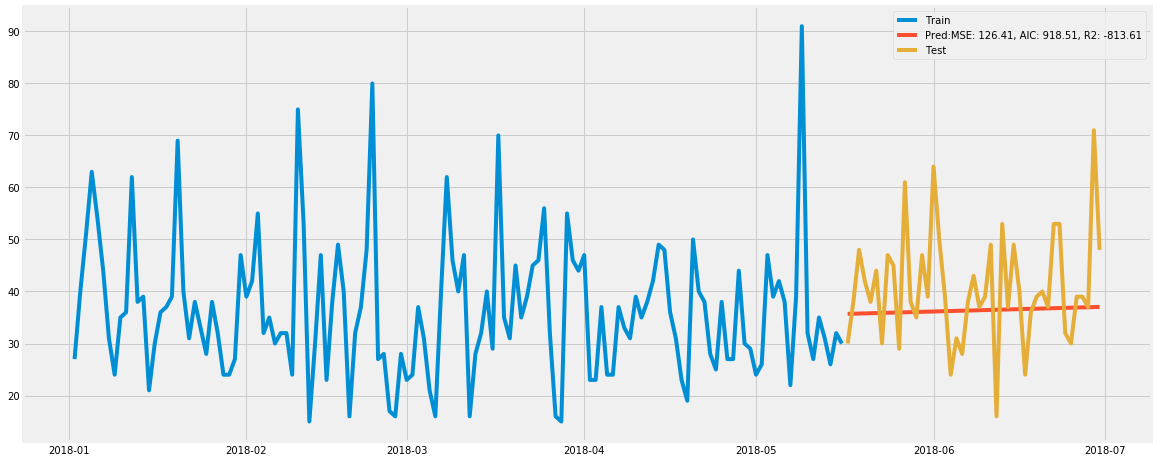

In [15]:
model = Holt(y_train)
params_range_dict ={"smoothing_level":list(np.arange(0,1,0.1)),
                    "smoothing_slope":list(np.arange(0,1,0.1))
                   }

mses,aics,params = model_hyparam_search(model,y_train,y_test,params_range_dict)

best_param = params[np.argmin(mses)]
mse = mses[np.argmin(mses)]
aic = aics[np.argmin(mses)]

holt = Holt(y_train).fit(*best_param,optimized=False)
holt_pred = holt.forecast(len(y_test))
r2 = r2_score(holt_pred,y_test)
plt.plot(y_train,label="Train")
plt.plot(holt_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test,label="Test")
plt.legend();

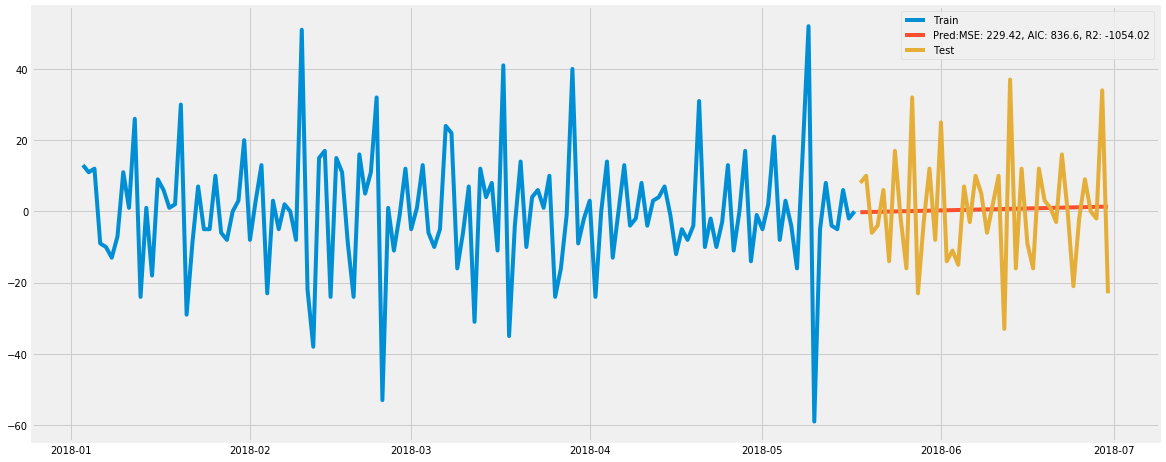

In [16]:
model = Holt(y_train_diff)
params_range_dict ={"smoothing_level":list(np.arange(0,1,0.1)),
                    "smoothing_slope":list(np.arange(0,1,0.1))
                   }

mses,aics,params = model_hyparam_search(model,y_train_diff,y_test_diff,params_range_dict)

best_param = params[np.argmin(mses)]
mse = mses[np.argmin(mses)]
aic = aics[np.argmin(mses)]

holt = Holt(y_train_diff).fit(*best_param,optimized=False)
holt_pred = holt.forecast(len(y_test_diff))
r2 = r2_score(holt_pred,y_test_diff)
plt.plot(y_train_diff,label="Train")
plt.plot(holt_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test_diff,label="Test")
plt.legend();

## ES

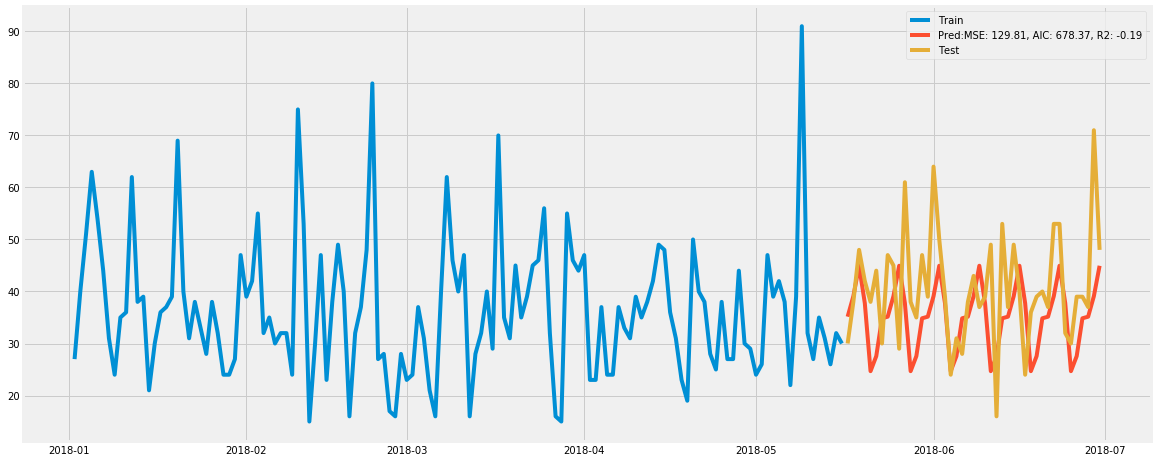

In [17]:
fit1 = ExponentialSmoothing(y_train, seasonal_periods=7, trend='add', seasonal='mul').fit(use_boxcox=True)
es_pred = fit1.forecast(len(y_test))

r2 = r2_score(y_test,es_pred)
mse = mean_squared_error(y_test,es_pred)
aic = fit1.aic

plt.plot(y_train,label="Train")
plt.plot(es_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test,label="Test")
plt.legend();

/home/garik/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


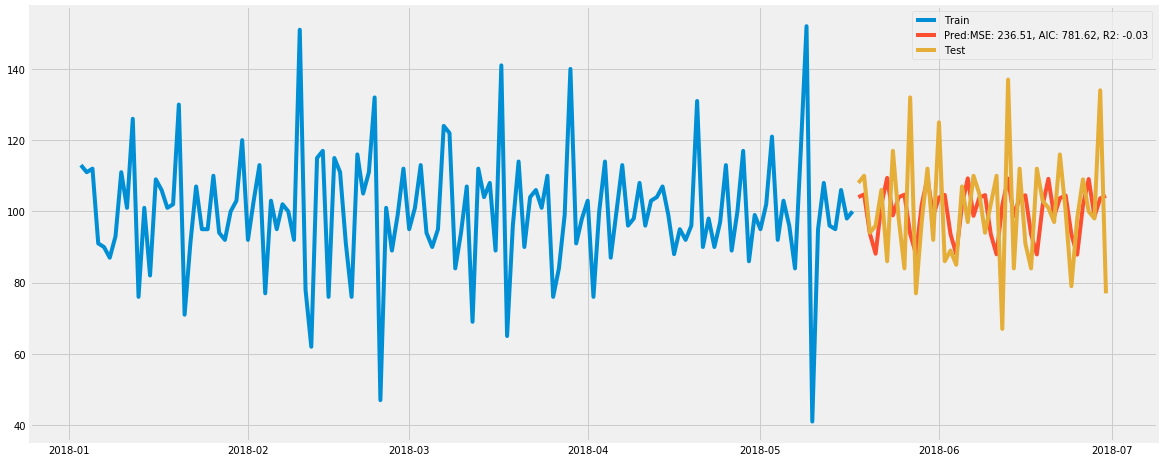

In [18]:
fit1 = ExponentialSmoothing(y_train_diff+100, seasonal_periods=7, trend='add', seasonal='mul').fit(use_boxcox=True)
es_pred = fit1.forecast(len(y_test_diff))

r2 = r2_score(y_test_diff+100,es_pred)
mse = mean_squared_error(y_test_diff+100,es_pred)
aic = fit1.aic

plt.plot(y_train_diff+100,label="Train")
plt.plot(es_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test_diff+100,label="Test")
plt.legend();

## ARIMA

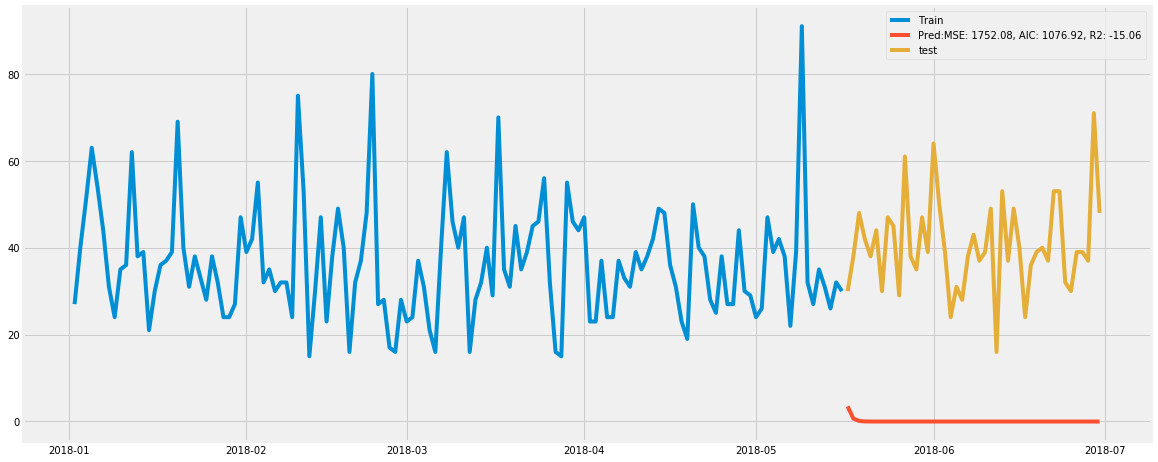

In [19]:
from statsmodels.tsa.arima_model import ARIMA

fitted = ARIMA(endog=y_train,order=(1,1,1)).fit(typ="level")
y_pred = fitted.predict(start=y_test.index[0],end=y_test.index[-1])

r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
aic = fitted.aic

plt.plot(y_train,label="Train")
plt.plot(y_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))

plt.plot(y_test,label="test")
plt.legend();

In [20]:


def model_hyparam_search(model,y_train,y_test,params_range_dict):


    params_range = list(params_range_dict.values())
    params = list(itertools.product(*params_range))
    
    aic, test_mse = [], []
    for param in params:
        try:
            print(param)
            fitted = model(endog=y_train,order=param).fit(enforce_invertibility=False,enforce_stationarity=False)
            y_pred = fitted.predict(start = y_test.index[0],end = y_test.index[-1])
            test_mse.append(mean_squared_error(y_pred,y_test))
            aic.append(fitted.aic)
        except:
            continue

    return test_mse,aic,params


params_range_dict ={"p":list(np.arange(0,3)),
                    "d":list(np.arange(0,2)),
                    "q":list(np.arange(0,2))
                   }


mses,aics,params = model_hyparam_search(ARIMA,y_train_diff,y_test_diff,params_range_dict)

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)
(2, 0, 0)
(2, 0, 1)
(2, 1, 0)
(2, 1, 1)


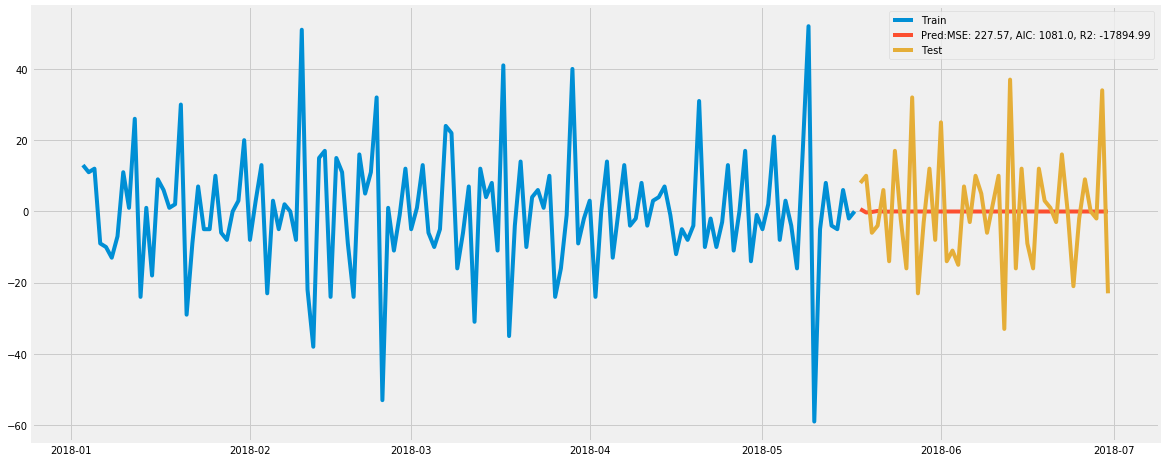

In [21]:
best_param = params[np.argmin(mses)]
mse = mses[np.argmin(mses)]
aic = aics[np.argmin(mses)]

model =  ARIMA(endog=y_train_diff,order=best_param).fit(enforce_invertibility=False,enforce_stationarity=False)
arime_pred = model.predict(start =y_test_diff.index[0], end = y_test_diff.index[-1])
r2 = r2_score(arime_pred,y_test_diff)
plt.plot(y_train_diff,label="Train")
plt.plot(arime_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test_diff,label="Test")
plt.legend();

## SARIMAX

In [22]:
import statsmodels.api as sm


In [23]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7 ) for x in list(itertools.product(p, d, q))]


results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            fitted = mod.fit()
            results.append([fitted.aic,param,param_seasonal])
        except:
            continue

/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/garik/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

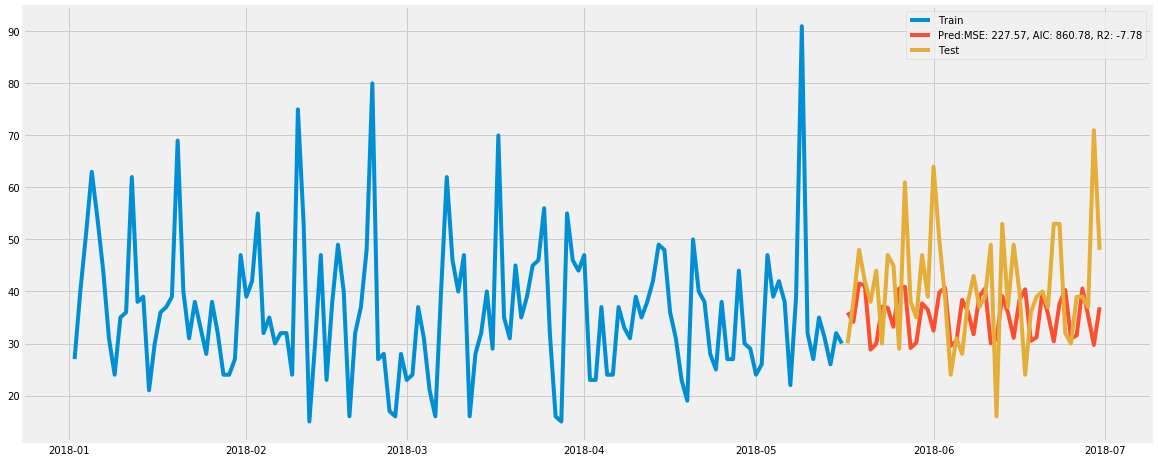

In [24]:
best_param,best_seasonal_param = results[np.argmin([res[0] for res in results])][1:]

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
fitted = mod.fit()
sarimax_pred = fitted.predict(start = y_test.index[0], end = y_test.index[-1])

r2 = r2_score(sarimax_pred,y_test)
plt.plot(y_train,label="Train")
plt.plot(sarimax_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(fitted.aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test,label="Test")
plt.legend();

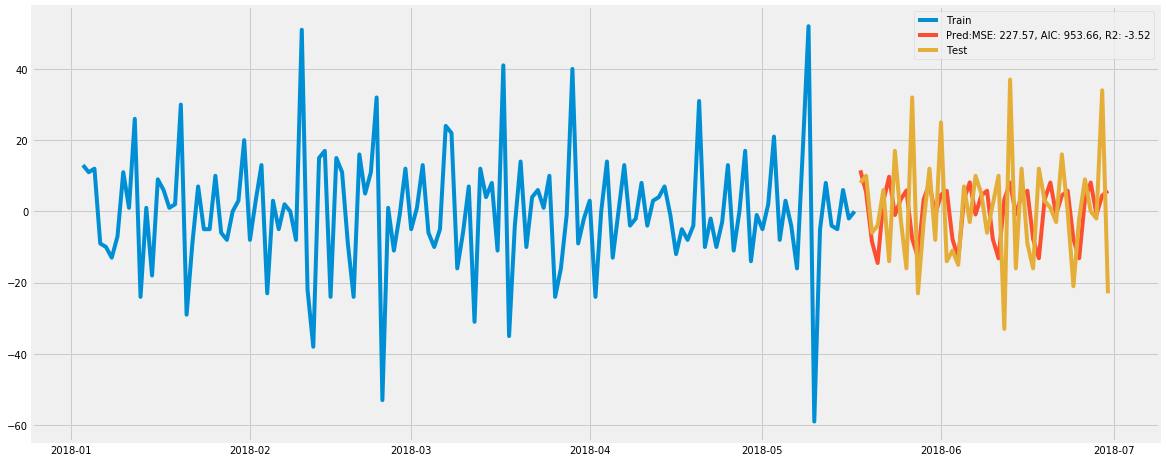

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7 ) for x in list(itertools.product(p, d, q))]


results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train_diff,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            fitted = mod.fit()
            results.append([fitted.aic,param,param_seasonal])
        except:
            continue
            
            
best_param,best_seasonal_param = results[np.argmin([res[0] for res in results])][1:]

mod = sm.tsa.statespace.SARIMAX(y_train_diff,
                                order=best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
fitted = mod.fit()
sarimax_pred = fitted.predict(start = y_test_diff.index[0], end = y_test_diff.index[-1])

r2 = r2_score(sarimax_pred,y_test_diff)
plt.plot(y_train_diff,label="Train")
plt.plot(sarimax_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(fitted.aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test_diff,label="Test")
plt.legend();

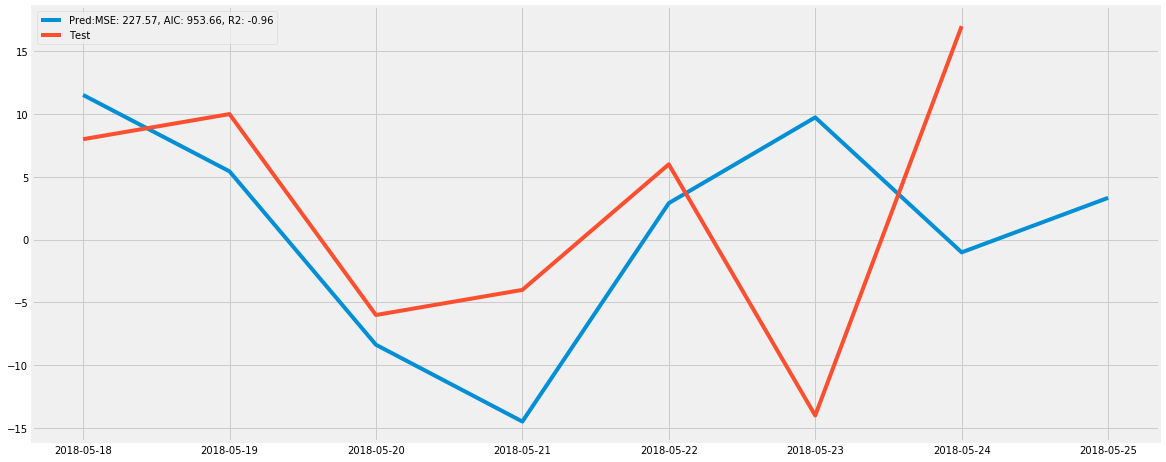

In [26]:
sarimax_pred = fitted.predict(start = y_test_diff.index[0], end = y_test_diff.index[7])
r2 = r2_score(sarimax_pred,y_test_diff[:8])
# plt.plot(y_train_diff,label="Train")
plt.plot(sarimax_pred,label="Pred:MSE: {}, AIC: {}, R2: {}".format(np.round(mse,2),
                                                                  np.round(fitted.aic,2),
                                                                  np.round(r2,2)))
                                                        
plt.plot(y_test_diff[:7],label="Test")
plt.legend();

## Temp data


In [52]:
temp_data_path = "../Datasets/forecast_temp_data.csv"
temp_data = 
pd.read_csv(temp_data_path)
temp_data.head()

SyntaxError: invalid syntax (<ipython-input-52-8c56c51e645f>, line 2)

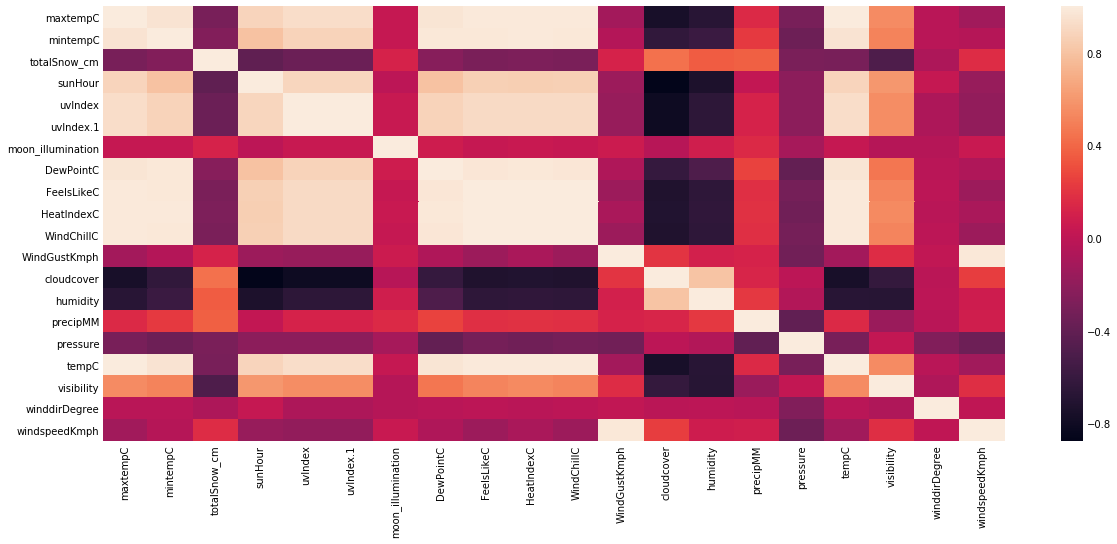

In [53]:
import seaborn as sns 

corrmap = temp_data.corr()
sns.heatmap(corrmap);

In [55]:
def create_time_series(data,col,time_col):
    series = data[[col]]
    series.set_index(data[time_col],inplace = True)
    series = series.resample(rule="D").sum()
    return series

In [56]:
temp = temp_data[["tempC"]].set_index(temp_data["date_time"])


In [57]:
dish1["temp"] = temp[:180]
# dish2["rain"] = rain[:180]

In [58]:
y_train_diff, y_test_diff = train_test_split(dish1.diff().dropna(),test_size=0.25)
y_train,y_test = train_test_split(dish1)

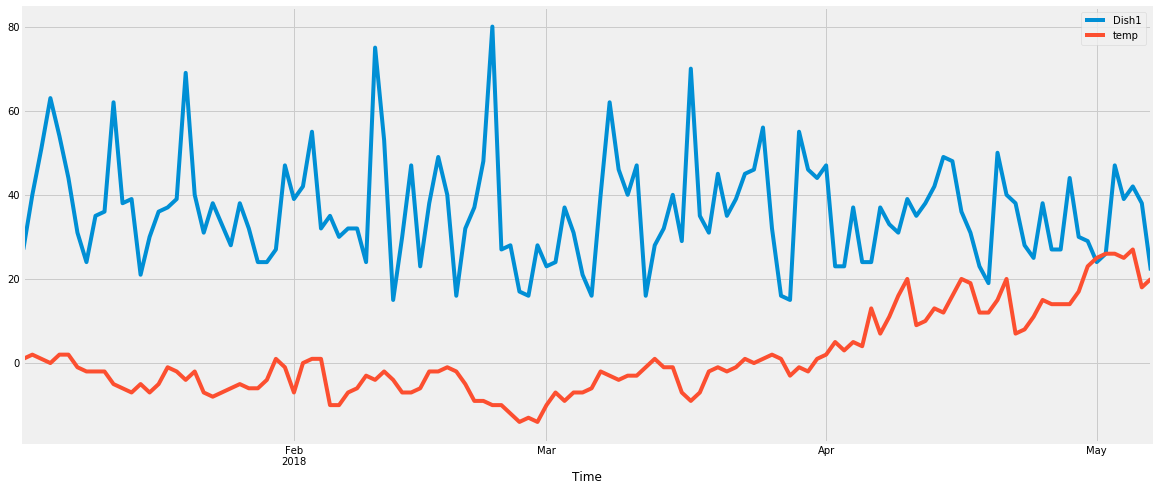

In [59]:
y_train.plot()

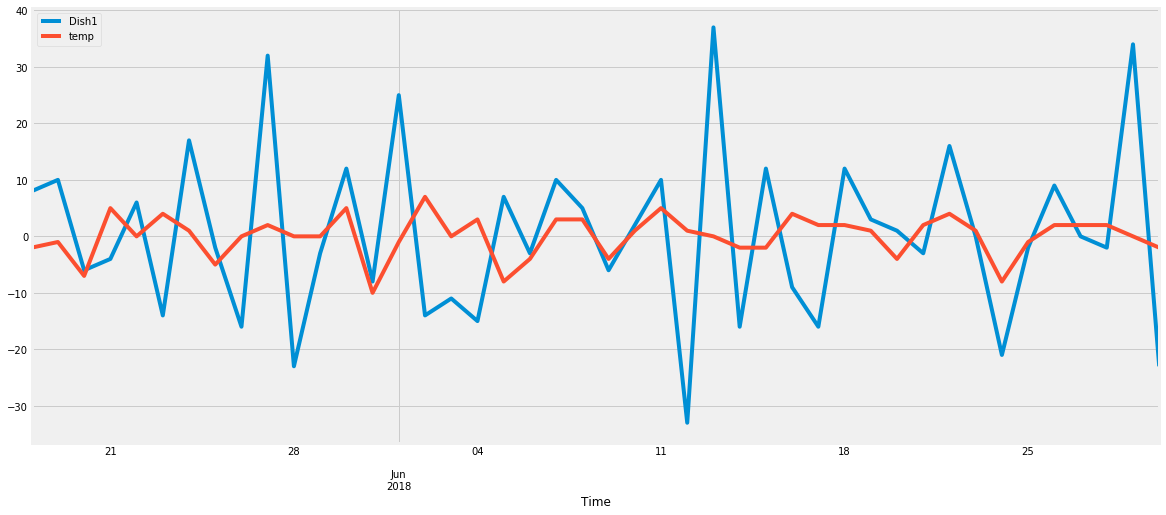

In [60]:
y_test_diff.plot();

In [61]:
from statsmodels.tsa.api import VAR

var = VAR(y_train_diff)
fitted = var.fit(maxlags=5)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Apr, 2020
Time:                     18:09:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.26231
Nobs:                     130.000    HQIC:                   7.97421
Log likelihood:          -852.431    FPE:                    2387.12
AIC:                      7.77703    Det(Omega_mle):         2029.19
--------------------------------------------------------------------
Results for equation Dish1
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.570261         1.221048           -0.467           0.640
L1.Dish1        -0.565725         0.085982           -6.580           0.000
L1.temp          0.505886         0.383553            1.319           0.187
L2.D

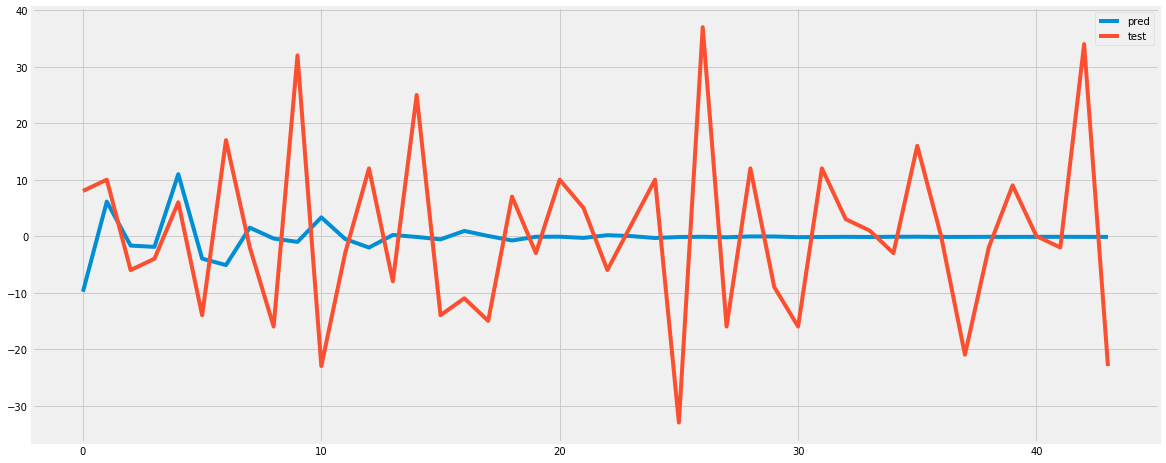

In [62]:
plt.plot(fitted.forecast(y_test_diff.values,len(y_test_diff))[:,0],label="pred")
plt.plot(y_test_diff["Dish1"].values,label="test")
plt.legend();
# plt.plot(y_test["temp"].values);

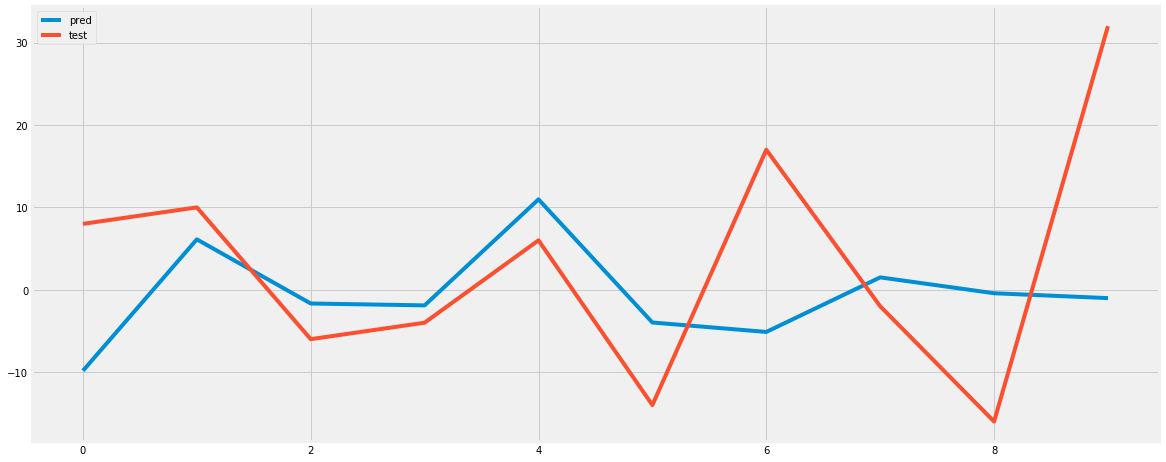

In [91]:
step_size = 10
plt.plot(fitted.forecast(y_test_diff.values,10)[:,0],label="pred")
plt.plot(y_test_diff["Dish1"].values[:step_size],label="test")
plt.legend();

## Holidays


In [41]:
import requests

url = "https://holidayapi.com/v1/holidays"
holiday_key = "6702c284-75ef-45dd-9bdb-5db9fb6aa084"

req = requests.get(url, params= {"key":"6702c284-75ef-45dd-9bdb-5db9fb6aa084",
                                 "country":"RU",
                                 "year":"2019",
                                })

request = req.json()

In [42]:
## available only for 2019 need to change 2018 
## https://stackoverflow.com/questions/33528913/change-time-in-timestamp

In [43]:
holidays = [obj["date"] for obj in request["holidays"]]
holidays = pd.to_datetime(holidays)
holidays = [holiday.date().replace(year=2018) for holiday in holidays]

In [44]:
is_holiday = []
for day in dish1.index:
    if day.date() in holidays:
        is_holiday.append(1)
    else:
        is_holiday.append(0)

In [45]:
dish1 = create_time_series(data,"Dish1",time_col)
temp = temp_data[["tempC"]].set_index(temp_data["date_time"])
dish1["temp"] = temp[:180]
dish1["holiday"] = is_holiday

In [ ]:
scl = StandardScaler()
scl.fit(dish1[["Dish1","temp"]])
scaled = scl.transform(dish1[["Dish1","temp"]])


scaled_df = pd.DataFrame(data=scaled,columns=["dish1","temp"])
scaled_df["holiday"] = is_holiday
scaled_df.set_index(dish1.index,inplace=True)

In [47]:
y_train,y_test = train_test_split(dish1)
y_train_diff,y_test_diff = train_test_split(dish1.diff().dropna(),test_size=0.25)

In [48]:
from statsmodels.tsa.api import VAR

var = VAR(y_train_diff)
results = var.fit(maxlags=5,ic="aic")
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Apr, 2020
Time:                     18:07:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.97178
Nobs:                     130.000    HQIC:                   6.34322
Log likelihood:          -889.731    FPE:                    371.207
AIC:                      5.91300    Det(Omega_mle):         262.052
--------------------------------------------------------------------
Results for equation Dish1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.676886         1.226027           -0.552           0.581
L1.Dish1          -0.519700         0.090216           -5.761           0.000
L1.temp            0.486245         0.388039            1.253           

175.20917984119052
-25.714015332627266


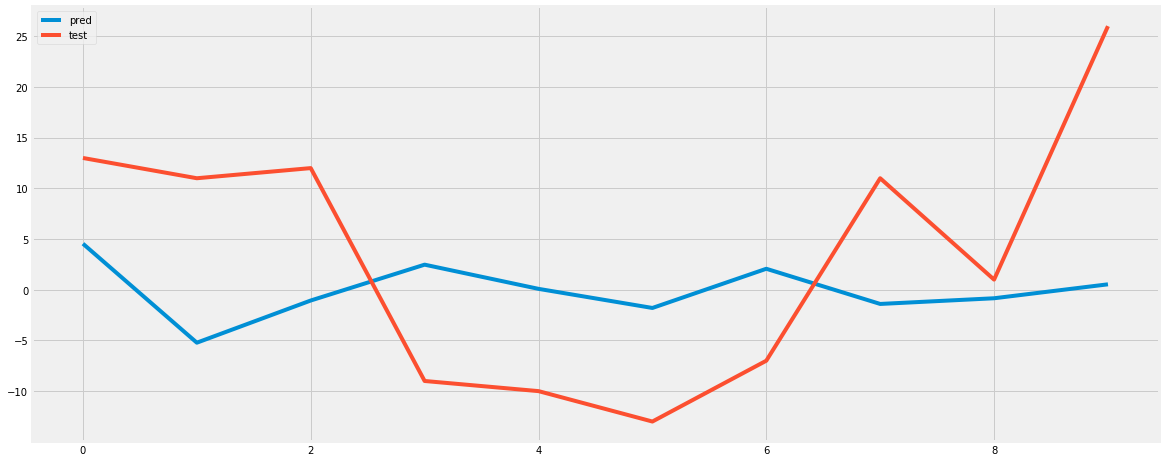

In [49]:
step_size = 10
y_scaled_pred = results.forecast(y_train_diff.values,step_size)[:,0]
print(mean_squared_error(y_scaled_pred,y_train_diff["Dish1"].values[:step_size]))
print(r2_score(y_scaled_pred,y_train_diff["Dish1"].values[:step_size]))

plt.plot(y_scaled_pred,label="pred")
plt.plot(y_train_diff["Dish1"].values[:step_size],label="test")
plt.legend();

In [ ]:
step_size = 10
y_scaled_pred = results.forecast(y_test_diff.diff().dropna().values,step_size)[:,0]
print(mean_squared_error(y_scaled_pred,y_test_diff["Dish1"].values[:step_size]))
print(r2_score(y_scaled_pred,y_test_diff["Dish1"].values[:step_size]))

plt.plot(y_scaled_pred,label="pred")
plt.plot(y_test_diff["Dish1"].values[:step_size],label="test")
plt.legend();

## Week days

In [ ]:
week_day = [date.weekday() for date in dish1.index]

In [ ]:
scaled_df["week_day"] = week_day

In [ ]:
dumm = pd.get_dummies(week_day,drop_first=1)
dumm = dumm.set_index(scaled_df.index)
scaled_df = pd.merge(scaled_df,dumm, how='inner', left_index=True, right_index=True)
scaled_df.drop(columns=["week_day"],inplace=True)

In [ ]:
scaled_df